In [1]:
import msprime, tskit
import numpy as np
from IPython.display import SVG
msprime.__version__

'1.1.1'

# Simulating mutations with msprime

First, we need to make it clear that you might not always need to do this.

In msprime simulations, the genealogy is created independently of the genetic variation. You simulate the underlying genealogy first, as a set of node and edge tables, and *then* if desired, you simulate mutations to go with that genealogical structure. All of the sequence and variation data in your simulation is simply a consequence of the mutations that you've thrown on top of the trees.

(Get a picture of a tree sequence with and without mutations)

However, in many situations, the genealogy is *all* you need. 

Think carefully. Does your application *need* information about alleles and mutations? If not, save yourself (and your computer) some effort.

Some examples of analyses that *do not* require this information include:
 - most analyses of ancestry, including local ancestry, global ancestry and identity-by-descent
 - most recent common ancestors
 - genealogical nearest neighbours
 - ...?

In later worksheets we will see some examples of these analyses.

But in this worksheet, we're going to focus on how to do mutation simulations, should you need to look at actual genome **sequences**....

 - 3.1 The basic syntax
 - 3.2 Mutation models
 - 3.3 Silent mutations and adjustments
 - 3.4 Stacked mutations
 - 3.5 Mutation rate variation
 - 3.6 Discrete and continuous coordinates
 - 3.7 Exporting into other formats

### A basic tree sequence to work with

To emphasise that mutations and genealogy are truly separate in msprime, we will use the same simulated genealogy (ie. node and edge table) in all of the simulations in this worksheet. Everything else we do will just be throwing different sets of mutations on top of these trees, to produce different genomic sequences.

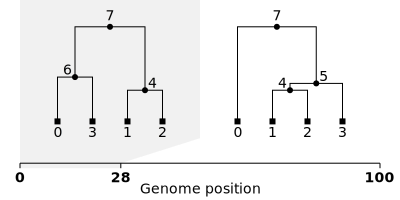

In [2]:
ts = msprime.sim_ancestry(2, sequence_length=100, random_seed=1987, recombination_rate=0.001)
SVG(ts.draw_svg())

In [3]:
ts_big = msprime.sim_ancestry(100, sequence_length=5e7, random_seed=1982, recombination_rate=1e-8)

## 3.1 The basic syntax

To simulate mutations, apply the `sim_mutations()` method to an existing tree sequence object.
At minimum, you must supply a per-base, per-generation mutation rate.

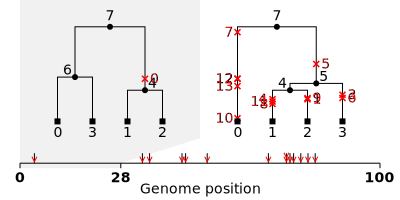

In [4]:
mts = msprime.sim_mutations(ts, rate=0.01, random_seed=2016)
SVG(mts.draw_svg())

By default, the mutation are simulated under a discrete *Jukes-Cantor* model, which we'll discuss further later on.
The output is yet another tree sequence, but this time with mutations on particular edges of the trees.
Under the hood, you'll notice that in addition to the node and edge table that were there before, there are now two new tables in the tree sequence.
One is a *mutations table*:

In [5]:
mts.tables.mutations

id,site,node,time,derived_state,parent,metadata
0,0,4,1.23594006,G,-1,b''
1,1,2,0.64084744,A,-1,b''
2,2,0,1.24046744,G,-1,b''
3,3,3,0.77282302,T,-1,b''
4,4,1,0.64477329,G,-1,b''
5,5,5,1.66530382,G,-1,b''
6,6,3,0.68047396,T,-1,b''
7,7,0,2.58755779,A,-1,b''
8,7,1,0.50759097,C,-1,b''
9,8,2,0.67574069,G,-1,b''


The other holds information about the sites at which these mutations arose.
Notice that some sites have experienced multiple mutations.

In [6]:
mts.tables.sites

id,position,ancestral_state,metadata
0,4.00000000,C,b''
1,34.00000000,C,b''
2,36.00000000,T,b''
3,45.00000000,C,b''
4,46.00000000,A,b''
5,52.00000000,T,b''
6,69.00000000,G,b''
7,74.00000000,G,b''
8,75.00000000,A,b''
9,76.00000000,A,b''


To view the sequence information, you have a few options. The `variants()` iterator:

In [7]:
for var in mts.variants():
    print(var.site.position, var.alleles, var.genotypes, sep="\t")

4.0	('C', 'G')	[0 1 1 0]
34.0	('C', 'A')	[0 0 1 0]
36.0	('T', 'G')	[1 0 0 0]
45.0	('C', 'T')	[0 0 0 1]
46.0	('A', 'G')	[0 1 0 0]
52.0	('T', 'G')	[0 1 1 1]
69.0	('G', 'T')	[0 0 0 1]
74.0	('G', 'A', 'C')	[1 2 0 0]
75.0	('A', 'G')	[0 0 1 0]
76.0	('A', 'G')	[1 0 0 0]
78.0	('C', 'A')	[0 1 0 0]
80.0	('G', 'T')	[1 0 0 0]
82.0	('T', 'C')	[1 0 0 0]


To get all alleles at once, can use `genotype_matrix()` (**only** if the tree sequence is small!!)

In [8]:
mts.genotype_matrix()

array([[0, 1, 1, 0],
       [0, 0, 1, 0],
       [1, 0, 0, 0],
       [0, 0, 0, 1],
       [0, 1, 0, 0],
       [0, 1, 1, 1],
       [0, 0, 0, 1],
       [1, 2, 0, 0],
       [0, 0, 1, 0],
       [1, 0, 0, 0],
       [0, 1, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0]], dtype=int8)

(Are there other ways? Ask others. Is there a way of getting all variants on a slice of the tree sequence)? VCF option discussed further down.

## Stacking mutations.

Note: you can apply `sim_mutations()` to *any* tree sequence, including one that already has mutations on it. This allows you to 'stack' mutations, which can be useful if you wish to simulate several different types of mutations from different models, over different time periods. 
There can be complicated statistical consequences of doing this that you need to be aware of and which we'll discuss soon, but for now, just note that it is possible and easy to do this:

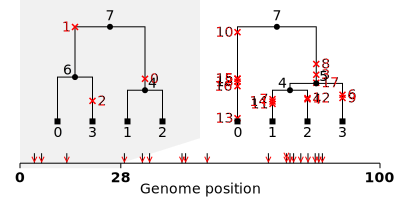

In [9]:
mmts = msprime.sim_mutations(mts, rate=0.01, random_seed=1959)
SVG(mmts.draw_svg())

Note that the tree sequence above is just the original one (below) with a few new mutations on it.

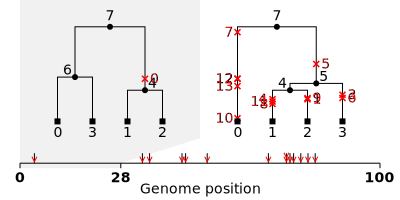

In [10]:
SVG(mts.draw_svg()) 

There's also no reason why you can't apply `sim_mutations()` to a tree sequence generated outside of `msprime`. (This may be particularly useful if you want to add neutral mutations to a SLiM-generated dataset).

## 3.2 Mutation models

By default, `msprime` invokes a Jukes-Cantor model of nucleotide mutations.
Under this model, there is an equal probability of each ancestral state (`A`, `C`, `G`, `T`), and an equal probability of each possible transition between these states (`A<->C`, `A<->G` etc).
This is defined in the model's `transition_matrix`:

In [11]:
msprime.JC69().transition_matrix

array([[0.        , 0.33333333, 0.33333333, 0.33333333],
       [0.33333333, 0.        , 0.33333333, 0.33333333],
       [0.33333333, 0.33333333, 0.        , 0.33333333],
       [0.33333333, 0.33333333, 0.33333333, 0.        ]])

In our case, we can eyeball all the mutations that has arisen in our simulations

In [12]:
for var in mts.variants():
    print(var.site.position, var.alleles, var.genotypes, sep="\t")

4.0	('C', 'G')	[0 1 1 0]
34.0	('C', 'A')	[0 0 1 0]
36.0	('T', 'G')	[1 0 0 0]
45.0	('C', 'T')	[0 0 0 1]
46.0	('A', 'G')	[0 1 0 0]
52.0	('T', 'G')	[0 1 1 1]
69.0	('G', 'T')	[0 0 0 1]
74.0	('G', 'A', 'C')	[1 2 0 0]
75.0	('A', 'G')	[0 0 1 0]
76.0	('A', 'G')	[1 0 0 0]
78.0	('C', 'A')	[0 1 0 0]
80.0	('G', 'T')	[1 0 0 0]
82.0	('T', 'C')	[1 0 0 0]


And summarise it like this, with some extra code

In [13]:
# Can I make the below code a bit more readable?
def count_transitions(ts, alleles):
    counts = np.zeros((len(alleles), len(alleles)), dtype='int')
    for s in ts.sites():
        aa = s.ancestral_state
        for m in s.mutations:
            pa = aa
            da = m.derived_state
            if m.parent != tskit.NULL:
                pa = ts.mutation(m.parent).derived_state
            counts[alleles.index(pa), alleles.index(da)] += 1
    print("\t", "\t".join(alleles))
    for j, a in enumerate(alleles):
        print(f"{a}\t", "\t".join(map(str, counts[j])))
        
count_transitions(mts, msprime.JC69().alleles)

	 A	C	G	T
A	 0	0	3	0
C	 2	0	1	1
G	 1	1	0	2
T	 0	1	2	0


In this case, we have a reasonably small number of mutations, so it's not necessarily obvious that our mutations satisfy the Jukes-Cantor model. This should be clearer looking at a larger dataset:

In [14]:
mts_big = msprime.sim_mutations(ts_big, rate=0.0001, random_seed=2016)
count_transitions(mts_big, msprime.JC69().alleles)

	 A	C	G	T
A	 0	8474	8374	8457
C	 8383	0	8421	8499
G	 8369	8556	0	8671
T	 8404	8515	8321	0


What are the other options?

### HKY

In some situations you'll want nucleotide transitions (`A<->G`), (`C<->T`) (ie. exchanges of bases with a similar shape) to be more likely than nucleotide tranversions (all others).
You can do this with the Hasegawa, Kishino & Yano (HKY) model.
In addition to a mutation `rate`, which specifies the probability of transversions, you also specify `kappa`, a constant scaling parameter such that the probability of transitions is `kappa` times the probability of transversions.

In [15]:
msprime.HKY(kappa=20).transition_matrix

array([[1.11022302e-16, 4.54545455e-02, 9.09090909e-01, 4.54545455e-02],
       [4.54545455e-02, 0.00000000e+00, 4.54545455e-02, 9.09090909e-01],
       [9.09090909e-01, 4.54545455e-02, 1.11022302e-16, 4.54545455e-02],
       [4.54545455e-02, 9.09090909e-01, 4.54545455e-02, 1.11022302e-16]])

You'll notice that there is now a very small (non-0) probability of *silent mutations* -- transitions from one state to the other. We'll discuss this soon.

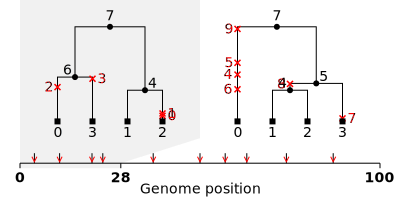

In [16]:
mts = msprime.sim_mutations(ts, rate=0.01, random_seed=2022, model=msprime.HKY(kappa=20))
SVG(mts.draw_svg())

Now, most of the mutations are transitions. (Also, note that the site with multiple mutations now experiences a back mutation).

In [17]:
for var in mts.variants():
    print(var.site.position, var.alleles, var.genotypes, sep="\t")

4.0	('G', 'T')	[0 0 1 0]
11.0	('C', 'T')	[0 0 1 0]
20.0	('C', 'A')	[1 0 0 0]
23.0	('T', 'C')	[0 0 0 1]
37.0	('A', 'G')	[1 0 0 0]
50.0	('G', 'A')	[1 0 0 0]
57.0	('T', 'C')	[1 0 0 0]
63.0	('C', 'T')	[0 0 0 1]
74.0	('A', 'G')	[0 1 1 0]
87.0	('C', 'T')	[1 0 0 0]


In [18]:
count_transitions(mts, msprime.HKY(kappa=20).alleles)

	 A	C	G	T
A	 0	0	2	0
C	 1	0	0	3
G	 1	0	0	1
T	 0	2	0	0


Again, the patterns will be a bit more statistically clear on a larger tree sequence.

In [19]:
mts_big = msprime.sim_mutations(ts_big, rate=0.0001, random_seed=2016, model=msprime.HKY(kappa=20))
count_transitions(mts_big, msprime.HKY(kappa=20).alleles)

	 A	C	G	T
A	 0	1148	23060	1096
C	 1148	0	1148	23007
G	 23210	1205	0	1177
T	 1147	22957	1141	0


### GTR

(Maybe omit this...)
For even more control, what if you want to specify each nucleotide substitution individually?
Then you want the GTR (Generalised Time-Reversible) model.
Would recommend looking up the documentation (put in a link) if you want to use this one, but essentially, in addition to specifying an equilibrium mutation `rate`, you also specify some `relative_rates`, which indicate the relative frequency of each of the possible nucleotide switches: (`A<->C`, `A<->G`, `A<->T`, `C<->G`, `C<->T`, `G<->T`).

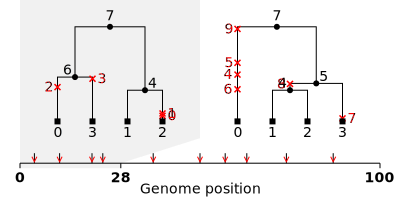

In [20]:
mts = msprime.sim_mutations(
    ts, rate=0.01, random_seed=2022, model=msprime.GTR(relative_rates=[1,2,1,2,1,2]))
SVG(mts.draw_svg())

### Binary mutation model
Two possible alleles: 0 and 1, the ancestral allele is always 0.

In [21]:
mts_big = msprime.sim_mutations(
    ts_big, rate=0.0001, random_seed=20278,
    model=msprime.BinaryMutationModel())
count_transitions(mts_big, msprime.BinaryMutationModel().alleles)

	 0	1
0	 0	100676
1	 18	0


### Models where the mutations aren't nucleotides

So far, we've been thinking about genomic locations in terms of nucleotides, and mutations as nucloeotide substitutions.
However, msprime just seems these genomic locations as numbers along a line, and there's no reason why those numbers can't represent other more general entities

(mention that you need to reinterpret/rescale recombination rate in this case)

In [22]:
mts = msprime.sim_mutations(ts, rate=0.01, random_seed=2022,
                            model=msprime.PAM())

Now, all of the variants are one of the first 20 letters in the latin alphabet, representing an amino acid of some sort. 

In [23]:
for var in mts.variants():
    print(var.site.position, var.alleles, var.genotypes, sep="\t")

4.0	('P', 'T')	[0 0 1 0]
11.0	('E', 'G')	[0 0 1 0]
20.0	('E', 'A')	[1 0 0 0]
23.0	('P', 'S')	[0 0 0 1]
37.0	('A',)	[0 0 0 0]
50.0	('L',)	[0 0 0 0]
57.0	('T', 'K')	[1 0 0 0]
63.0	('G',)	[0 0 0 0]
74.0	('D', 'S')	[0 1 1 0]
87.0	('I', 'K')	[1 0 0 0]


In this case, *many* of the mutations are now silent.

In [24]:
# mts_big = msprime.sim_mutations(ts_big, rate=0.0001, random_seed=2016, model=msprime.PAM())
# count_transitions(mts_big, msprime.PAM().alleles)

### Make-your-own mutation model!
Maximum flexibility:
 - alleles (the possible 'choices' you can see at each unit
 - root distribution (what's the distribution of ancestral alleles?)
 - transition matrix (what's the probability of mutating from one allele to another?)

In [25]:
model = msprime.MatrixMutationModel(
    alleles = ["💩", "🎄", "🔥"],
    root_distribution = [1.0, 0.0, 0.0],
    transition_matrix = [[0.0, 1.0, 0.0],
                         [0.0, 0.8, 0.2],
                         [1.0, 0.0, 0.0]]
)
mts = msprime.sim_mutations(ts, rate=0.01, random_seed=1215112, model=model)

for var in mts.variants():
    print(var.site.position, var.alleles, var.genotypes, sep="\t")

13.0	('💩', '🎄')	[0 1 1 0]
24.0	('💩', '🎄', '🔥')	[2 0 0 1]
31.0	('💩', '🎄')	[0 1 1 1]
53.0	('💩', '🎄')	[0 1 1 1]
83.0	('💩', '🎄')	[0 0 1 0]


## 3.3 Silent mutations, state independence and related adjustments

Some things I've drawn attention to before:
 - mutations that apparently don't change the allelic state
 - non-0 diagonal entries in some transition matrices
 - the complications of simulating with stacked mutations

Note that some of these are *silent mutations*, which do not change the allelic state. This the main 'gotcha' to keep in mind with some of these mutation models.

Let's have a closer look at some of the transition matrices of the models we've looked at:

In [26]:
msprime.JC69().transition_matrix

array([[0.        , 0.33333333, 0.33333333, 0.33333333],
       [0.33333333, 0.        , 0.33333333, 0.33333333],
       [0.33333333, 0.33333333, 0.        , 0.33333333],
       [0.33333333, 0.33333333, 0.33333333, 0.        ]])

In [27]:
msprime.HKY(kappa=20).transition_matrix

array([[1.11022302e-16, 4.54545455e-02, 9.09090909e-01, 4.54545455e-02],
       [4.54545455e-02, 0.00000000e+00, 4.54545455e-02, 9.09090909e-01],
       [9.09090909e-01, 4.54545455e-02, 1.11022302e-16, 4.54545455e-02],
       [4.54545455e-02, 9.09090909e-01, 4.54545455e-02, 1.11022302e-16]])

In [28]:
msprime.PAM().transition_matrix[:4,:4]

array([[2.53731698e-01, 6.14375962e-03, 2.23224538e-02, 3.15381787e-02],
       [1.30864303e-02, 5.14926581e-01, 7.41589866e-03, 0.00000000e+00],
       [4.81027017e-02, 7.50247128e-03, 1.11022302e-16, 2.34774581e-01],
       [5.86240591e-02, 0.00000000e+00, 2.02517620e-01, 2.08958712e-01]])

In [29]:
np.sum(msprime.PAM().transition_matrix[1,:])

1.0

In particular, notice that some of the diagonal entries are non-zero. This indicates that there is a positive probability of mutations where the ancestral and derived state are the same. We have observed instances of these above.

Why does `msprime` simulate these `silent mutations`? The short answer is that it is...

The most important thing is that we know how to deal with it, and in particular, how to adjust for it. We might usually thing that when we specify a mutation rate, we are specifying a rate of mutations which change the allelic state. The consequence of using this mutation rate with a model that includes silent mutations is that we will have fewer varying sites than we might expect to produce, which in turn leads to underestimates of statistics relying on these, like diversity, segregating sites etc.

If you are using an msprime mutation model where some fraction of the mutations are non-0, we need to figure out what fraction of our mutations are expected to be silent, and adjust our mutation rate accordingly. Link [here](https://tskit.dev/msprime/docs/stable/mutations.html#adjusting-mutation-rates-for-silent-mutations)

Note that the probability of an `A<->A` transition is *more* likely than an `A->B`, `A->C`, `A->D` transition etc!
This produces silent mutations.
The reason why this happens: it's a workaround to ensure that `msprime` does not simulate nonsensical mutations.
Let's see how to adjust the mutation rate for the PAM model:

$$ \mu = \mu_{silent} + \mu_{non-silent}$$

and

$$ \mu_{silent} = \sum_i T_{i, i} $$
where $T_{i, j}$ is the $(i, j)$th element of the transition matrix for this mutation model.

In [30]:
T_pam = msprime.PAM().transition_matrix
silent_prop = np.sum(np.diag(T_pam))/np.sum(T_pam)
silent_prop

0.4522391449735115

So 45% of our mutations will be silent. We therefore need to adjust our mutation rates to make up for this 'missing' 45%. $\mu \left( 1 + 45/55 \right)$, right?

These 'silent' mutations are just a mathematical artifact. Basically, in order to ensure that you throw down mutations that are consistent with each other, msprime makes this tradeoff -- you simulate variant mutations that are at a rate that is *proportional* to those specified by the model. You then need to adjust for this.

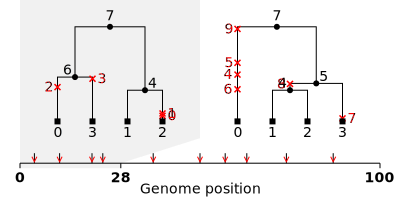

In [31]:
mts = msprime.sim_mutations(ts, rate=0.01, random_seed=2022,
                            model=msprime.PAM())
SVG(mts.draw_svg())

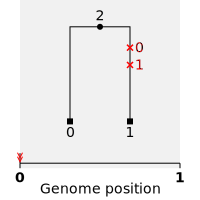

In [32]:
ts_1locus = msprime.sim_ancestry(1, sequence_length=1, random_seed=1991)
mts_1locus = msprime.sim_mutations(ts_1locus, rate=0.5, random_seed=42,
                            model=msprime.JC69())
SVG(mts_1locus.draw_svg())

In [33]:
for var in mts_1locus.variants():
    print(var.site.position, var.alleles, var.genotypes, sep="\t")

0.0	('A', 'G')	[0 0]


In [34]:
mts_1locus.tables.mutations

id,site,node,time,derived_state,parent,metadata
0,0,1,1.14736585,G,-1,b''
1,0,1,0.87830371,A,0,b''


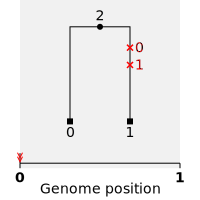

In [35]:
ts_1locus = msprime.sim_ancestry(1, sequence_length=1, random_seed=1991)
mts_1locus = msprime.sim_mutations(ts_1locus, rate=0.5, random_seed=42,
                            model=msprime.JC69(state_independent=False))
SVG(mts_1locus.draw_svg())

In [36]:
mts_1locus.tables.mutations

id,site,node,time,derived_state,parent,metadata
0,0,1,1.14736585,G,-1,b''
1,0,1,0.87830371,A,0,b''


'mutation flags', are they a thing?

mention the SLiM mutation model, for anyone using SLiM

## 3.5 Mutation rate variation

You can specify mutation hotspots using the `RateMap` method as an argument to `rate`, instead of the single number:

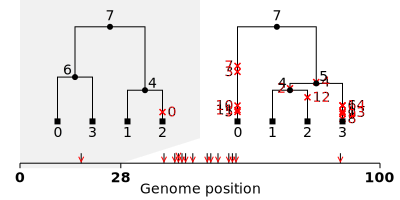

In [37]:
ratemap = msprime.RateMap(position=[0, 40, 60, 100], rate=[0.01, 0.1, 0.01])
mts = msprime.sim_mutations(ts, rate=ratemap, random_seed=104)
SVG(mts.draw_svg())

### Exercise:
Modify the following code to simulate mutations on top of the `ts` tree sequence, using a blah blah model where transpositions are 5 times more likely than transversions, with a hotspot between locations 25 and 50.

## 3.6 Mutation rates in different epochs

Use the `start_time` and `end_time` arguments to simulate mutations only within specific timeframes:

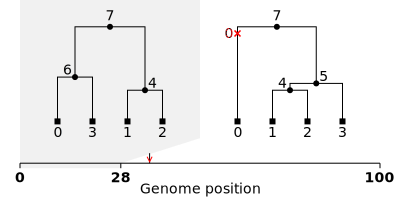

In [38]:
mts = msprime.sim_mutations(ts, rate=0.01, random_seed=1714, start_time=2)
SVG(mts.draw_svg())

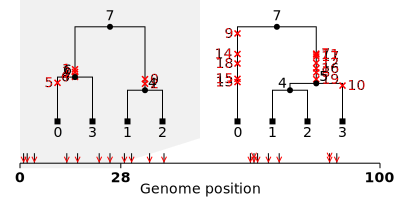

In [39]:
mmts = msprime.sim_mutations(mts, rate=0.1, random_seed=851, start_time=1,
                            end_time=2)
SVG(mmts.draw_svg())

In [40]:
mts.tables.mutations

id,site,node,time,derived_state,parent,metadata
0,0,0,2.55114999,C,-1,b''


In [41]:
# Why does msprime renumber the mutations?
mmts.tables.mutations

id,site,node,time,derived_state,parent,metadata
0,0,4,1.22526182,A,-1,b''
1,1,6,1.51236165,T,-1,b''
2,2,4,1.09327036,A,-1,b''
3,3,6,1.43375150,C,-1,b''
4,4,6,1.32335367,G,-1,b''
5,5,0,1.11966184,T,-1,b''
6,6,6,1.28982931,C,-1,b''
7,7,5,1.96575343,T,-1,b''
8,8,5,1.42068890,T,-1,b''
9,9,0,2.55114999,C,-1,b''


*Exercise*. Over the past 50 generations, your study organisms were exposed to an environmental mutagen that induces additional mutations uniformly across their genomes at a rate of 1e-6 per generation. Modify the code below to model these circumstances.

 ## 3.6 Discrete vs continuous coordinates
 
 As with `sim_ancestry()`, we can choose whether to place mutations at discrete (integer) or continuous (floating point) positions. Use the `discrete_genome` argument:

In [42]:
mts = msprime.sim_mutations(ts, rate=0.01, random_seed=2016,
                           discrete_genome=False)

for var in mts.variants():
    print(var.site.position, var.alleles, var.genotypes, sep="\t")

4.402867715805769	('C', 'G')	[0 1 1 0]
34.85179366543889	('C', 'A')	[0 0 1 0]
36.57769249379635	('T', 'G')	[1 0 0 0]
45.47010489925742	('C', 'T')	[0 0 0 1]
46.209049480967224	('A', 'G')	[0 1 0 0]
52.59616706520319	('T', 'G')	[0 1 1 1]
69.75686146877706	('G', 'T')	[0 0 0 1]
74.16516633238643	('G', 'A')	[0 1 0 0]
74.18320943415165	('C', 'A')	[1 0 0 0]
75.6578678265214	('G', 'A')	[0 0 1 0]
76.12467459589243	('C', 'G')	[1 0 0 0]
78.32757562864572	('A', 'T')	[0 1 0 0]
80.26015576906502	('G', 'T')	[1 0 0 0]
82.46896007284522	('C', 'T')	[1 0 0 0]


(Our mutational model now confirms to the classical *infinite sites* assumption).

## 3.7 Exporting sequence data into other formats

To run analyses using the sequence data you've just simulated, you have a lot of different approaches to consider.
One thing that I'll mention briefly now, demonstrate fully later, is that there is a lot you can do using the tree sequence objects on their own. If there is a way to do the operation using `tskit`, we recommend it, as on realistically sized datasets, it will almost always be quicker and more memory-efficient.
However sometimes you can't avoid exporting the data into another format, like VCF, in order to work with other software

### To VCF
Basic syntax:

In [43]:
mts.num_individuals

2

In [44]:
with open("worksheet3-output.vcf", "w") as vcf_file:
    mts.write_vcf(vcf_file)

What the output looks like

In [45]:
with open("worksheet3-output.vcf", "r") as f:
    print(f.read())

##fileformat=VCFv4.2
##source=tskit 0.4.1
##FILTER=<ID=PASS,Description="All filters passed">
##contig=<ID=1,length=100>
##FORMAT=<ID=GT,Number=1,Type=String,Description="Genotype">
#CHROM	POS	ID	REF	ALT	QUAL	FILTER	INFO	FORMAT	tsk_0	tsk_1
1	4	.	C	G	.	PASS	.	GT	0|1	1|0
1	35	.	C	A	.	PASS	.	GT	0|0	1|0
1	37	.	T	G	.	PASS	.	GT	1|0	0|0
1	45	.	C	T	.	PASS	.	GT	0|0	0|1
1	46	.	A	G	.	PASS	.	GT	0|1	0|0
1	53	.	T	G	.	PASS	.	GT	0|1	1|1
1	70	.	G	T	.	PASS	.	GT	0|0	0|1
1	74	.	G	A	.	PASS	.	GT	0|1	0|0
1	74	.	C	A	.	PASS	.	GT	1|0	0|0
1	76	.	G	A	.	PASS	.	GT	0|0	1|0
1	76	.	C	G	.	PASS	.	GT	1|0	0|0
1	78	.	A	T	.	PASS	.	GT	0|1	0|0
1	80	.	G	T	.	PASS	.	GT	1|0	0|0
1	82	.	C	T	.	PASS	.	GT	1|0	0|0



Fancier version, if you want to specify your own individual names:

In [46]:
indv_names = ["platypus_1", "platypus_2"]
with open("worksheet3-output.vcf", "w") as vcf_file:
    mts.write_vcf(vcf_file, individual_names=indv_names)

In [47]:
with open("worksheet3-output.vcf", "r") as f:
    print(f.read())

##fileformat=VCFv4.2
##source=tskit 0.4.1
##FILTER=<ID=PASS,Description="All filters passed">
##contig=<ID=1,length=100>
##FORMAT=<ID=GT,Number=1,Type=String,Description="Genotype">
#CHROM	POS	ID	REF	ALT	QUAL	FILTER	INFO	FORMAT	platypus_1	platypus_2
1	4	.	C	G	.	PASS	.	GT	0|1	1|0
1	35	.	C	A	.	PASS	.	GT	0|0	1|0
1	37	.	T	G	.	PASS	.	GT	1|0	0|0
1	45	.	C	T	.	PASS	.	GT	0|0	0|1
1	46	.	A	G	.	PASS	.	GT	0|1	0|0
1	53	.	T	G	.	PASS	.	GT	0|1	1|1
1	70	.	G	T	.	PASS	.	GT	0|0	0|1
1	74	.	G	A	.	PASS	.	GT	0|1	0|0
1	74	.	C	A	.	PASS	.	GT	1|0	0|0
1	76	.	G	A	.	PASS	.	GT	0|0	1|0
1	76	.	C	G	.	PASS	.	GT	1|0	0|0
1	78	.	A	T	.	PASS	.	GT	0|1	0|0
1	80	.	G	T	.	PASS	.	GT	1|0	0|0
1	82	.	C	T	.	PASS	.	GT	1|0	0|0



### To other Python objects

Many of the underlying attributes of tskit objects are `numpy` objects, so play well with other Python libraries, including plotting libraries like `matplotlib` and scientific libraries like `scikit-allel`.

In particular, the `genotype_matrix` method will return an object that works as a HaplotypeArray in scikit-allel, which gives you access to summary functions.

In [48]:
import allel

(Confusingly named `genotype matrix`, but is actually haplotypes)

In [49]:
gens = mts.genotype_matrix()
print(gens)

[[0 1 1 0]
 [0 0 1 0]
 [1 0 0 0]
 [0 0 0 1]
 [0 1 0 0]
 [0 1 1 1]
 [0 0 0 1]
 [0 1 0 0]
 [1 0 0 0]
 [0 0 1 0]
 [1 0 0 0]
 [0 1 0 0]
 [1 0 0 0]
 [1 0 0 0]]


Can easily be converted into the right objects for analyses with `allel`.

In [50]:
haps = allel.HaplotypeArray(gens)
allele_counts = haps.count_alleles()

In [51]:
%%time
allel.mean_pairwise_difference(allele_counts)

CPU times: user 218 µs, sys: 31 µs, total: 249 µs
Wall time: 280 µs


array([0.66666667, 0.5       , 0.5       , 0.5       , 0.5       ,
       0.5       , 0.5       , 0.5       , 0.5       , 0.5       ,
       0.5       , 0.5       , 0.5       , 0.5       ])

But, this takes a long time on big datasets. Some of these operations can be done much more quickly within tskit itself, which we'll get to next time.